In [1]:
import numpy as np
print("numpy version: {}".format(np.__version__))
import networkx as nx
print("Networkx version: {}".format(nx.__version__))
from time import time
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set()

import numexpr
numexpr.print_versions()

numpy version: 1.16.5
Networkx version: 2.3
*Warning*: NumPy version is lower than recommended: 1.16.5 < 1.7.0
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Numexpr version:   2.6.9
NumPy version:     1.16.5
Python version:    3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
Platform:          linux-x86_64-#1 SMP Fri Jun 14 02:54:29 EDT 2019
CPU vendor:        
CPU model:         
CPU clock speed:    MHz
VML available?     False
Number of threads used by default: 24 (out of 24 detected cores)
Maximum number of threads: 64
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [2]:
import tensorflow as tf
print(tf.__version__)

if tf.test.gpu_device_name() == '/device:GPU:0':
  print("Using a GPU")
else:
  print("Using a CPU")

2.0.0-rc1
Using a CPU


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np
import seaborn as sns; sns.set_context('notebook')

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

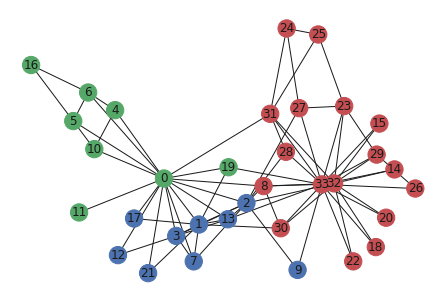

In [5]:
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
G = nx.karate_club_graph()
c = list(greedy_modularity_communities(G))
# show first 5 graphs
pos = nx.spring_layout(G)
colors = np.array(['r', 'b', 'g'])
label = np.arange(0,len(G))
label[list(c[0])] = 0
label[list(c[1])] = 1
label[list(c[2])] = 2
nx.draw(G, node_color=colors[label], with_labels=True, pos=pos)
plt.show()
plt.close()

In [6]:
#Define the joint_log_prob function, and our unnormalized posterior.
def SBM_log_prob(w, x, Gs, k, labels, weighted=False, directed=False, selfloops=False):
  # the SBM log-likelihood
  # input can be a single graph or a list of graphs
    if isinstance(Gs, nx.Graph):
        Gs = [Gs]
    n = len(Gs[0])
    # whether to include the diagonal or not
    if selfloops:
        triu_indices = np.triu_indices(n, k=1)
    else:
        triu_indices = np.triu_indices(n)
    # convert to adjacency matrix
    # if graph is undirected, we just need the upper triangular part
    if directed:
        A_obs = np.array([nx.to_numpy_array(G) for G in Gs])
    else:
        A_obs = np.array([nx.to_numpy_array(G)[triu_indices] for G in Gs])
    
    a = np.ones(k)
    pi = tfd.Dirichlet(a)
    z = tfd.Categorical(probs=pi)


        pi = pm.Dirichlet('pi', a=np.ones(k), shape=(k,))
        z = pm.Categorical('z', p=pi, shape=(n,))
        if weighted:
            eta = pm.Gamma('eta', alpha=.001, beta=.001, shape=(k, k))
        else:
            eta = pm.Beta('eta', alpha=1, beta=1, shape=(k, k))
        # parameters to sample the adjacency matrix
        # p[i, j] = eta[z[i], z[j]] is the parameter corresponding to A[i, j]
        p = eta[(z.reshape((n, 1)), z.reshape((1, n)))] # very inefficient parameterization
        if not selfloops:
            TT.set_subtensor(p[np.diag_indices(n)], 0.)
        if not directed:
            p = eta[(z.reshape((n, 1)), z.reshape((1, n)))][triu_indices] #replace with equation 5.5 for analytical posterior, including DC?
            print(p)
        if weighted:
            A = pm.Poisson('A', mu=p, shape=A_obs[0].shape, observed=A_obs) #collect edge/non-edge statistics for the analytical posterior
        else:
            A = pm.Bernoulli('A', p=p, shape=A_obs[0].shape, observed=A_obs)
    return model
  

array([[0., 0.],
       [0., 0.]])

In [5]:
from tensorflow_probability import edward2 as ed
a = np.ones(3)
pi = tfd.Dirichlet(a)

In [ ]:
# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unnormalized_posterior,
  step_size=np.float64(.1),
  num_leapfrog_steps=2)

# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
  return tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_state,
    kernel=hmc_kernel,
    trace_fn=lambda current_state, kernel_results: kernel_results)

In [ ]:
initial_state = np.zeros(num_features + 1)
samples, kernel_results = run_chain(initial_state)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

In [53]:
def fast_pymc3_sbm(Gs, k, labels, weighted=False, directed=False, selfloops=False):
    # input can be a single graph or a list of graphs
    if isinstance(Gs, nx.Graph):
        Gs = [Gs]
    n = len(Gs[0])
    # whether to include the diagonal or not
    if selfloops:
        triu_indices = np.triu_indices(n, k=1)
    else:
        triu_indices = np.triu_indices(n)
    # convert to adjacency matrix
    # if graph is undirected, we just need the upper triangular part, needs to updated
    #if directed:
        A_obs = np.array([nx.to_numpy_array(G) for G in Gs])
    #else:
        #A_obs = np.array([nx.to_numpy_array(G)[triu_indices] for G in Gs])

    cumulator = theano.shared(np.zeros((k, k), dtype=np.float32)) # block-pairwise edge/non-edge statistics for the analytical posterior
    modelFast = pm.Model()
    with modelFast:
        pi = pm.Dirichlet('pi', a=np.ones(k), shape=(k,))
        z = pm.Categorical('z', p=pi, shape=(n,))
        
        #Collect block-pairwise edge/non-edge statistics for the analytical posterior
        for i in range(len(G)):
            for j in range(i+1, len(G)):
                cumulate_value_at_position(z[i], z[j], nx.to_numpy_array(G)[i,j])
        #Calculate analytical posterior. Weighted(counting) version to be updated
        if weighted:
            eta = pm.Gamma('eta', alpha=.001, beta=.001, shape=(k, k)) #replace with equation 5.5 for analytical posterior, including DC?
        else:
            for i in range(k):
                for j in range(k):
                    eta = pm.Beta(f'eta_{i}_{j}', alpha=1, beta=1, shape=(k, k), observed=cumulator[i,j])
        # parameters to sample the adjacency matrix
        # p[i, j] = eta[z[i], z[j]] is the parameter corresponding to A[i, j]
        # p = eta[(z.reshape((n, 1)), z.reshape((1, n)))] # all p and eta will be integrated out
    return modelFast

In [12]:
def make_pymc3_sbm(Gs, k, labels, weighted=False, directed=False, selfloops=False):
    # input can be a single graph or a list of graphs
    if isinstance(Gs, nx.Graph):
        Gs = [Gs]
    n = len(Gs[0])
    # whether to include the diagonal or not
    if selfloops:
        triu_indices = np.triu_indices(n, k=1)
    else:
        triu_indices = np.triu_indices(n)
    # convert to adjacency matrix
    # if graph is undirected, we just need the upper triangular part
    if directed:
        A_obs = np.array([nx.to_numpy_array(G) for G in Gs])
    else:
        A_obs = np.array([nx.to_numpy_array(G)[triu_indices] for G in Gs])

    model = pm.Model()
    with model:
        pi = pm.Dirichlet('pi', a=np.ones(k), shape=(k,))
        z = pm.Categorical('z', p=pi, shape=(n,))
        if weighted:
            eta = pm.Gamma('eta', alpha=.001, beta=.001, shape=(k, k))
        else:
            eta = pm.Beta('eta', alpha=1, beta=1, shape=(k, k))
        # parameters to sample the adjacency matrix
        # p[i, j] = eta[z[i], z[j]] is the parameter corresponding to A[i, j]
        p = eta[(z.reshape((n, 1)), z.reshape((1, n)))] # very inefficient parameterization
        if not selfloops:
            TT.set_subtensor(p[np.diag_indices(n)], 0.)
        if not directed:
            p = eta[(z.reshape((n, 1)), z.reshape((1, n)))][triu_indices] #replace with equation 5.5 for analytical posterior, including DC?
            print(p)
        if weighted:
            A = pm.Poisson('A', mu=p, shape=A_obs[0].shape, observed=A_obs) #collect edge/non-edge statistics for the analytical posterior
        else:
            A = pm.Bernoulli('A', p=p, shape=A_obs[0].shape, observed=A_obs)
    return model

In [55]:
k = 2
labels = np.full(shape=len(G),fill_value=0)
labels[::3] = 1
model = make_pymc3_sbm(G, k, labels)
with model as m1:
    #start = pm.find_MAP()
    #trace = pm.sample(50000, start=start, progressbar=True)
    trace1 = pm.sample(80000, tune = 20000, target_accept = 0.9,  cores = 12)
modelFast = fast_pymc3_sbm(G, k, labels)
with modelFast as m2:
    trace2 = pm.sample(80000, tune = 20000, target_accept = 0.9,  cores = 12)

NameError: name 'make_pymc3_sbm' is not defined

In [54]:
modelFast = fast_pymc3_sbm(G, k, labels)
with modelFast as m2:
    trace2 = pm.sample(80000, tune = 20000, target_accept = 0.9,  cores = 12)

NameError: name 'k' is not defined

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c534cfa58>,
      dtype=object)

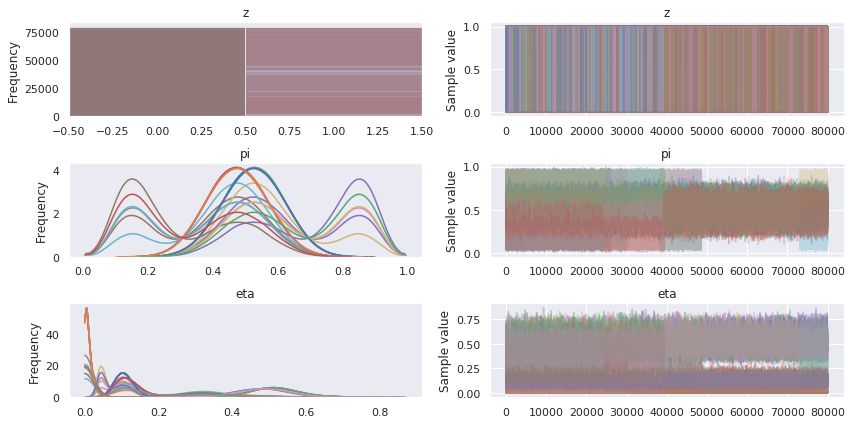

In [23]:
pm.traceplot(trace1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c53ba2e48>,
      dtype=object)

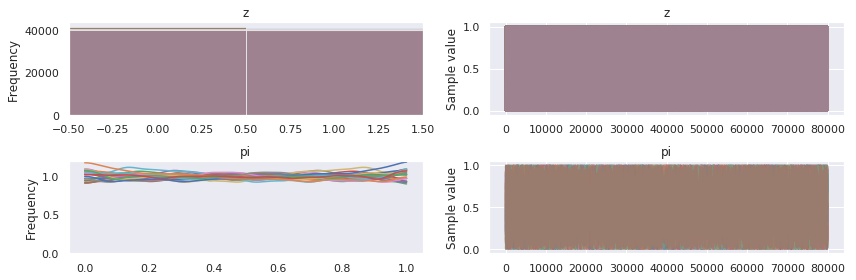

In [39]:
pm.traceplot(trace2)

In [ ]:
np.savetxt('test.csv',np.mean(trace1['z']),delimiter=",")

In [ ]:
def updateDAG(G, NodeMerge):
    size = len(NodeMerge);
    u,v = NodeMerge[0]
    for i in range (0,size):
        print(NodeMerge[i])
    A = nx.adjacency_matrix(G).todense()
    while len(NodeMerge)>0:
        nodes = NodeMerge.pop()
        B = np.vstack([A, (A[nodes[0],:]+A[nodes[1],:])/2])
        A = np.column_stack([B, (B[:,nodes[0]]+B[:,nodes[1]])/2])
    dt=[('weight',float)]
    A = np.matrix(A,dtype=dt)
    H = nx.from_numpy_matrix(A)
    H.remove_node(u)
    H.remove_node(v)
    #print(H.node())
    return H

In [ ]:
def getCandidates(G, labels):
    A = nx.adjacency_matrix(G).todense()
    np.fill_diagonal(A, 9999)
    am = A.argmin() #find min pair
    c0 = am % A.shape[1]
    r0 = am // A.shape[1]
    A[c0,r0] = 9999
    A[r0,c0] = 9999
    c1 = A[r0,:].argmin() #find 2nd min pair
    r1 = A[:,c0].argmin() #find 2nd min pair
    
    Llist = []    
    labelsNew = labels.copy()
    labelsNew[r0] = labelsNew[c0]
    b,c =np.unique(labelsNew, return_inverse=True)
    Llist.append(c)
    labelsNew = labels.copy()
    labelsNew[r0] = labelsNew[c1]
    b,c =np.unique(labelsNew, return_inverse=True)
    Llist.append(c)
    labelsNew = labels.copy()
    labelsNew[c0] = labelsNew[r1]
    b,c =np.unique(labelsNew, return_inverse=True)
    Llist.append(c)
    return Llist

In [ ]:
def buildLayer(G, k, Llist):
    Mlist = []
    Tlist = []

    for iteration in range (0,3):
        labels = Llist[iteration]
        model = make_pymc3_sbm(G, k, labels)
        with model as modelX:
            trace = pm.sample(1500, tune = 500)
        Mlist.append(modelX)
        Tlist.append(trace)

    Mlist[0].name = '0'
    Mlist[1].name = '1'
    Mlist[2].name = '2'
    comp = pm.compare({Mlist[0]: Tlist[0], Mlist[1]: Tlist[1], Mlist[2]: Tlist[2]}, method='BB-pseudo-BMA')
    #print(comp.weight)
    return comp.weight

In [ ]:
from collections import Counter

label = np.array([0, 1, 2, 3, 4, 5, 6, 7])
Gnew = G
while True:
    k = len(Gnew)
    label = np.arange(k)
    Llist = getCandidates(Gnew,label)
    ModelPosterior = buildLayer(Gnew, k-1, Llist)
    thresh = ModelPosterior['0'] + 0.3 #use the closest pair as the posterior threshold, increase to speed up convergence
    newInternal = ModelPosterior[ModelPosterior  > thresh].index.astype(int)
    NodeMerge = [] #nodes to be merged, closest pair added as the defult
    dup = [item for item, count in Counter(Llist[0]).items() if count > 1]
    nodes = np.where(Llist[0] == dup[0])
    NodeMerge.append(nodes[0])
    print(Llist[0])
    for i in range (0,len(newInternal)):
        newLabel = Llist[newInternal[i]]
        print(newLabel)
        dup = [item for item, count in Counter(newLabel).items() if count > 1]
        nodes = np.where(newLabel == dup[0])
        NodeMerge.append(nodes[0])
    Gnew = updateDAG(Gnew, NodeMerge) #update the graph with node mergers/splits
    if k<=3:
        break  

In [ ]:
from sklearn.preprocessing import LabelEncoder

documents = [['Python', 'Scala', 'Python', 'Python', 'Java'],
             ['Scala', 'Python', 'Python', 'Java', 'Scala'],
             ['Python', 'Python', 'Scala', 'Python'],
             ['Java', 'Java', 'Java', 'Scala', 'Scala'],
             ['Scala', 'Scala', 'Scala', 'Python', 'Java', 'Scala', 'deep learning'],
             ['Python', 'Scala', 'Python', 'Python', 'Python', 'machine learning'],
             ['Java', 'Python', 'Python', 'Java', 'Scala'],
             ['deep learning', 'statistics', 'machine learning', 'Python'],
             ['machine learning', 'machine learning', 'deep learning', 'deep learning', 'machine learning'],
             ['statistics', 'Python', 'statistics', 'statistics', 'deep learning', 'Postgres'],
             ['deep learning', 'machine learning', 'machine learning', 'deep learning', 'deep learning', 'Postgres'],
             ['MySQL', 'Cassandra', 'Postgres', 'Postgres', 'Postgres', 'machine learning'],
             ['Cassandra', 'Cassandra', 'Postgres', 'Scala', 'MySQL', 'MySQL']]

# Number of topics
K = 3

# Number of documents 
D = len(documents)

# (Ab)use label encoder for categorical encoding of words
encoder = LabelEncoder()
encoder.fit([word for document in documents for word in document])

# Vocabulary derived from documents
vocabulary = encoder.classes_

# Vocabulary size 
V = len(vocabulary)

# Encoded documents
X = [encoder.transform(d) for d in documents]

In [ ]:
import numpy as np
import pymc3 as pm

# Hyper-parameter for uniform Dirichlet prior
alpha = np.ones(K)

# Hyper-parameter for sparse Dirichlet prior
beta = np.ones(V) * 0.3

with pm.Model() as model:
    # Global topic distribution
    theta = pm.Dirichlet('theta', a=alpha)
    
    # Word distributions for K topics
    phi = pm.Dirichlet('phi', a=beta, shape=(K, V))
    
    # Topic of documents
    z = pm.Categorical('z', p=theta, shape=(D,))
    
    for i in range(D):
        # Words of document
        w = pm.Categorical(f'w_{i}', p=phi[z[i]], observed=X[i])

In [ ]:
with model:    
    trace = pm.sample(2000, chains=1)

In [ ]:
#pm.plot_posterior(trace);
model.basic_RVs

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_phi_estimates(trace):
    plt.figure(figsize=(20,5))
    for i in range(K):
        plt.subplot(1, 3, i+1)
        for j in range(V):
            sns.distplot(trace['phi'][:, i, j], kde=True, hist=False, label=vocabulary[j])
            plt.ylim([0, 10])
        plt.title(f'Phi density estimates for topic {i}')
        plt.legend(vocabulary)
        
plot_phi_estimates(trace)

In [ ]:


for i in range(D):
    topics, counts = np.unique(trace['z'][:, i], return_counts=True)
    print(f'Topic of document {i: >2} = {topics[np.argmax(counts)]}')



In [ ]:
pm.traceplot(trace)